# Tagging genes with ddlite: learning and rule iteration

## Introduction
In this example **ddlite** app, we'll build a gene tagger from scratch. Here's why we developed ddlite:

* To provide a lighter-weight interface to structured information extraction for new DeepDive users
* To help advanced DeepDive rapidly develop and prototype applications and distant supervision rules
* To investigate DeepDive's data programming approach to building inference systems

This example is centered around the second item. Domain-specific tagging systems take months or years to develop. They use hand-crafted model circuitry and accurate, hand-labeled training data. We're going to try to build a pretty good one in a few minutes with none of those things. The generalized extraction and learning utilities provided by ddlite will allow us to turn a sampling of article abstracts and some basic domain knowledge into an automated tagging system. Specifically, we want an accurate tagger for genes in academic articles. We have comprehensive dictionaries of genes, but applying a simple matching rule might yield a lot of false positives. For example, "p53" might get tagged as a gene if it refers to a page number. Our goal is to use distant supervision to improve precision.

Here's the pipeline we'll follow:

1. Obtain and parse input data (relevant article abstracts from PubMed)
2. Extract candidates for tagging
3. Generate features
4. Write distant supervision rules
5. Learn the tagging model
6. Iterate on distant supervision rules

Parts 3 through 6 are covered in this notebook. It requires candidates extracted from `GeneTaggerExample_Extraction.ipynb`, which covers parts 1 and 2.

In [1]:
%load_ext autoreload
%autoreload 2

import cPickle
from ddlite import *

## Loading candidate extractions
First, we'll load in the pickled candidates that we created in the last notebook. We can construct an `Entities` object with the file.

In [2]:
E = Entities('gene_tag_example/gene_tag_saved_entities.pkl')

## `ExtractionInference` objects and feature generation
We'll then create an `ExtractionInference` object for our extracted gene candidates. This lets us iterate with our model and distant supervision rules. Since `Entities` defines a feature generation method, features are automatically created when we initialize an `ExtractionInference` object. These are generic features from the NLP markup and dependency tree in the neighborhood of the mention.

In [3]:
I = ExtractionInference(E)
print "Extracted {} features for each of {} mentions".format(I.num_feats(), I.num_extractions())

Extracted 35966 features for each of 1518 mentions


## Writing distant supervision rules
We'll use distant supervision to learn a logistic regression model which will predict the probability of a candidate entity being a true gene mention. Since our training data is not labelled, we'll generate many (potentially noisy) rules as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite as we'll soon see. Writing distant supervision rules is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with distant supervision rules. These can be used either to create a simple standalone app, or to plug into DeepDive. Rules are functions that take an `Extraction` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple rules to get started:

* The first rule returns a positive label if the mention candiate contains the word "gene", and abstains otherwise
* The second rule returns a positive label if the dependency parent of any of the words in the mention is "mutation", and abstains otherwise

In [4]:
def rule_1(m):
    return 1 if 'gene' in [m.lemmas[i] for i in m.idxs] else 0
def rule_2(m):
    return 1 if 'mutation' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0

The two rules given above won't yield a good model (especially since there are no negative examples). To create meaningful results, write more distant supervision rules! After writing the rules, we simply collect them and apply them to mentions. If we define more rules later, we can apply them incrementally or overwrite all the rules so far.

In [5]:
rules = [rule_1, rule_2]
I.apply_rules(rules)
print "Applied {} rules to {} mentions with {} positives, {} abstains, and {} negatives.".format(I.num_rules(),
        I.num_extractions(), I.num_rules('pos'), I.num_rules('abs'), I.num_rules('neg'))

Applied 2 rules to 1518 mentions with 66 positives, 2970 abstains, and 0 negatives.


## Learning
To learn weights for the features and rules, we use a simple, regularized logistic regression model. Again, the results won't be meaningful without more rules.

In [6]:
%time I.learn_weights(nSteps=5000, sample=False, mu=1e-6, holdout=0.1, use_sparse=True, verbose=True)


Learning epoch =  0	100	200	300	400	
Learning epoch =  500	600	700	800	900	
Learning epoch =  1000	1100	1200	1300	1400	
Learning epoch =  1500	1600	1700	1800	1900	
Learning epoch =  2000	2100	2200	2300	2400	
Learning epoch =  2500	2600	2700	2800	2900	
Learning epoch =  3000	3100	3200	3300	3400	
Learning epoch =  3500	3600	3700	3800	3900	
Learning epoch =  4000	4100	4200	4300	4400	
Learning epoch =  4500	4600	4700	4800	4900	CPU times: user 22.2 s, sys: 64 ms, total: 22.2 s
Wall time: 22.4 s


We can examine the learned weights for each feature and rule

In [7]:
print "Rule weights: {}".format(I.w[:I.num_rules()])
print "Some feature weights: {}".format(I.w[I.num_rules():I.num_rules()+10])

Rule weights: [ 0.99995     1.01561024]
Some feature weights: [ 0.00030111  0.00028163  0.0002035   0.00034187  0.00024248  0.00019598
  0.00105315  0.00021365  0.00043712  0.00019022]


or look at the predicted probability of each mention candidate being an actual gene mention

In [8]:
print "Some predicted mention probabilities: {}".format(I.get_predicted_probability()[:10])

Some predicted mention probabilities: [ 0.9105971   0.77202473  0.93012844  0.80789889  0.83712977  0.7206435
  0.79640562  0.93649581  0.83510939  0.82560782]


We can use [DeepDive-style calibration plots](http://deepdive.stanford.edu/calibration) to evaluate the quality of our predictions. We aren't using a holdout set right now, so let's just look at the histogram of probabilities.

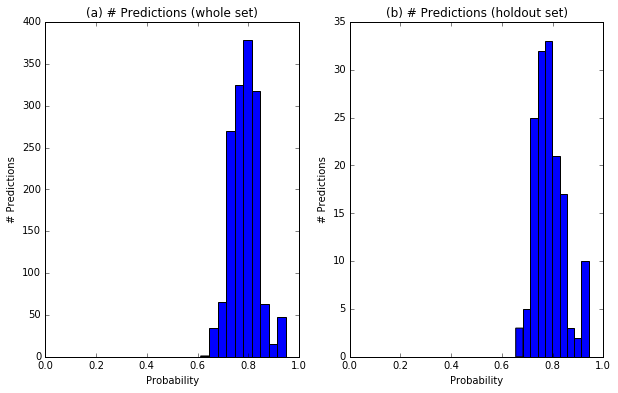

In [9]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)

I.plot_calibration()

## Error Analysis

Now, let's look at a sample of extractions using [Mindtagger](http://deepdive.stanford.edu/labeling).  We can use a shorthand to create a Mindtagger task and launch it right from the notebook:

In [10]:
I.open_mindtagger(num_sample=20, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


In [12]:
tags = I.get_mindtagger_tags()
print tags

[{u'is_correct': True, u'ext_id': 1399}, {u'is_correct': True, u'ext_id': 827}, {u'is_correct': False, u'ext_id': 769}, {u'is_correct': False, u'ext_id': 509}, {u'is_correct': True, u'ext_id': 998}, {u'is_correct': True, u'ext_id': 1097}, {u'is_correct': True, u'ext_id': 995}, {u'is_correct': True, u'ext_id': 470}, {u'is_correct': True, u'ext_id': 854}, {u'ext_id': 836}, {u'ext_id': 529}, {u'ext_id': 684}, {u'ext_id': 262}, {u'ext_id': 362}, {u'ext_id': 1422}, {u'ext_id': 1272}, {u'ext_id': 846}, {u'ext_id': 787}, {u'ext_id': 1216}, {u'ext_id': 176}]


In [13]:
tagged_exts = [tag for tag in tags if u'is_correct' in tag]
num_correct = sum(1 for tag in tagged_exts if tag[u'is_correct'])
"precision = %3.f%%" % (100 * num_correct * 1.0 / len(tagged_exts))

'precision =  78%'